**Course Announcements**

Due Friday (11:59 PM):
- D8
- A4
- weekly project survey (*optional*)


# Geospatial Analysis

- Analysis:
    - Exploratory Spatial Data Analysis
    - K-Nearest Neighbors

- Tools:
    - `shapely` - create and manipulate shape objects
    - `geopandas` - shapely + dataframe + visualization
   

Today's notes are adapted from the [Scipy 2018 Tutorial - Introduction to Geospatial Data Analysis with Python](https://github.com/geopandas/scipy2018-geospatial-data).

To get all notes and examples from this workshop, do the following:
```
git clone https://github.com/geopandas/scipy2018-geospatial-data    # get materials
conda env create -f environment.yml                                 # download packages
python check_environment.py                                         # check environment 
```

Additional resource for mapping data with `geopandas`: http://darribas.org/gds15/content/labs/lab_03.html

In [ ]:
# uncomment below if not yet installed
%pip install geopandas
%pip install descartes

In [ ]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 10

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

# `geopandas` basics

Examples here are from `geopandas` documentation: http://geopandas.org/mapping.html

## The Data

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [ ]:
world

In [ ]:
cities

## Population Estimates

In [ ]:
# Plot population estimates with an accurate legend
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
world.plot(column='pop_est', ax=ax, legend=True);

In [ ]:
# Plot population estimates with a different color scale
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
world.plot(column='pop_est', ax=ax, cmap='GnBu', legend=True);

## GDP per capita

In [ ]:
# Plot by GDP per capita

# specify data
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

# plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
world.plot(column='gdp_per_cap', ax = ax, figsize=(17, 6), cmap='GnBu', legend = True);

In [ ]:
world[world['gdp_per_cap'] > 0.08]

In [ ]:
# combining maps
base = world.plot(column='pop_est', cmap='GnBu')
cities.plot(ax=base, marker='o', color='red', markersize=5);

## Geospatial Analysis

- Data
- EDA (Visualization)
- Analysis

### District data: Berlin

In [ ]:
# berlin districts
df = gpd.read_file('https://raw.githubusercontent.com/geopandas/scipy2018-geospatial-data/master/data/berlin-districts.geojson')

In [ ]:
df.shape

In [ ]:
df.head()

### Exploratory Spatial Data Analysis

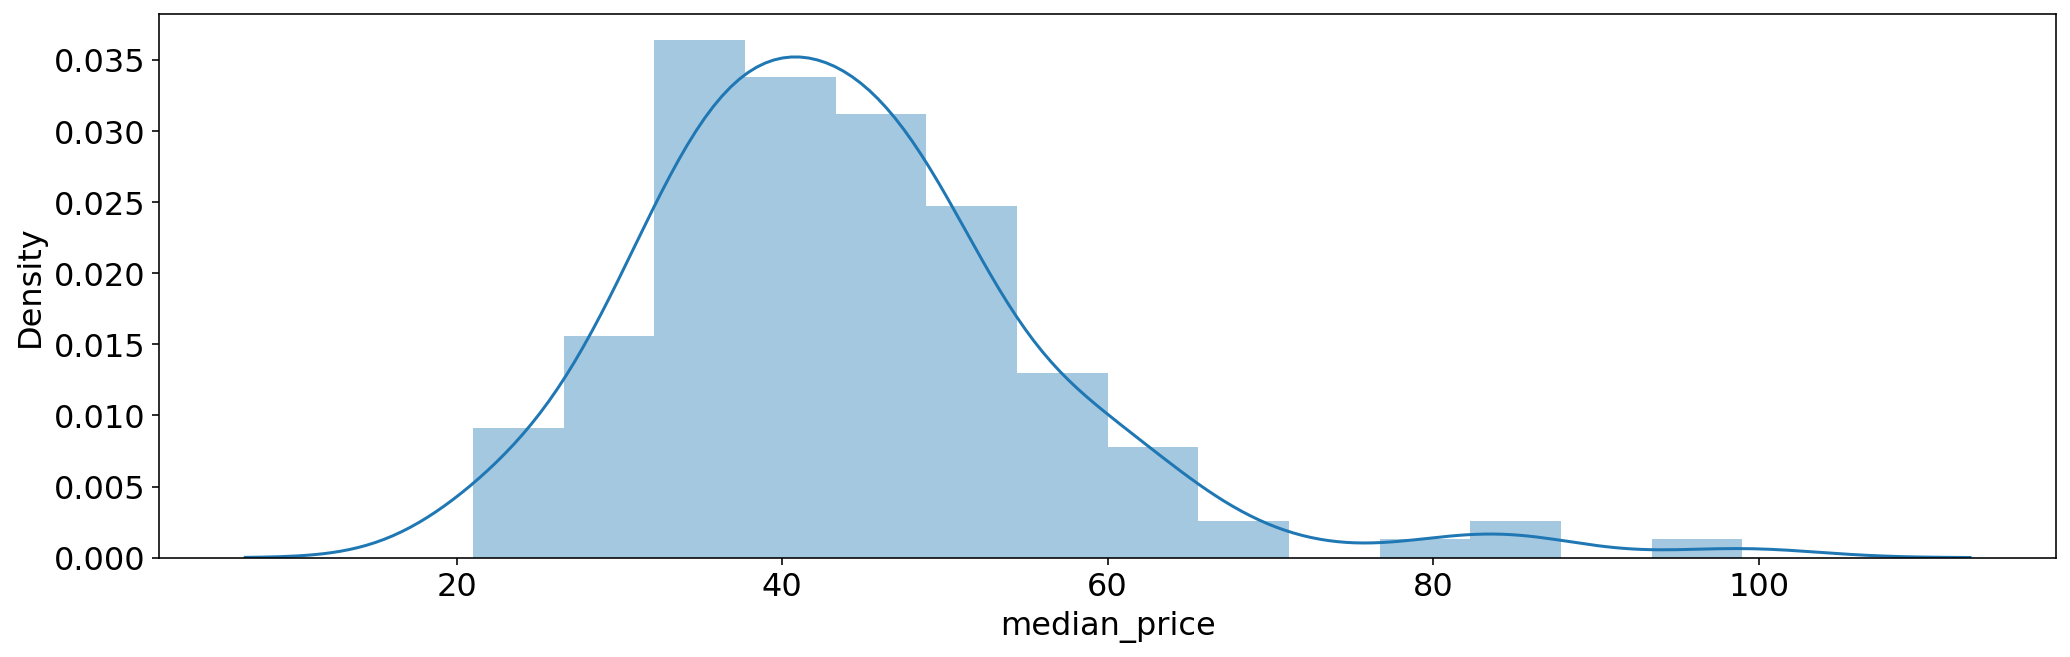

In [38]:
sns.distplot(df['median_price']);

We get an idea of what the median price for listings in this area of Berlin is, but we don't know how this information is spatially related.

In [ ]:
df.plot(column='median_price', figsize=(18, 12), cmap='GnBu', legend=True);

Unless you happen to know something about this area of Germany, interpreting what's going on in this choropleth is likely a little tricky, but we can see there is some variation in median prices across this region.

### Spatial Autocorrelation

Note that if prices were distributed randomly, there would be no clustering of similar values.

To visualize the existence of global spatial autocorrelation, let's take it to the extreme. Let's look at the 68 districts with the highest Airbnb prices and those with the lowest prices.

In [ ]:
# get data to dichotomize
y = df['median_price']
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

In [ ]:
# take a look
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
df.plot(column='yb', cmap='binary',
        edgecolor='grey', legend=True, ax=ax);

### Airbnb Listings: Berlin

- kernel regressions
    - "borrow strength" from nearby observations

A reminder that in geospatial data, there *two simultaneous senses of what is near:*
- things that similar in attribute (classical kernel regression)
- things that are similar in spatial position (spatial kernel regression)


### Question

What features would you consider including in a model to predict an Airbnb's nightly price?


First, though, let's try to predict the log of an **Airbnb's nightly price** based on a few factors:
- `accommodates`: the number of people the airbnb can accommodate
- `review_scores_rating`: the aggregate rating of the listing
- `bedrooms`: the number of bedrooms the airbnb has
- `bathrooms`: the number of bathrooms the airbnb has
- `beds`: the number of beds the airbnb offers

### Airbnb Listings: The Data

In [ ]:
listings = pd.read_csv('https://raw.githubusercontent.com/geopandas/scipy2018-geospatial-data/master/data/berlin-listings.csv.gz')
listings['geometry'] = listings[['longitude', 'latitude']].apply(shp.Point, axis=1)
listings = gpd.GeoDataFrame(listings)
listings.crs = {'init':'epsg:4269'} # coordinate reference system
listings = listings.to_crs(epsg=3857)

In [ ]:
listings.shape

In [ ]:
listings.head()

### Airbnb Listings: Outcome Variable

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
divider = make_axes_locatable(ax)
listings.sort_values('price').plot('price', cmap='plasma', 
                                   figsize=(10, 18), ax=ax, legend=True);

In [ ]:
# distribution of price
sns.distplot(listings['price']);

In [ ]:
listings['price_log'] = np.log(listings['price'])

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
divider = make_axes_locatable(ax)
listings.sort_values('price_log').plot('price_log', cmap='plasma', 
                                       figsize=(10, 18), ax=ax, legend=True);

In [ ]:
# distribution of log price
sns.distplot(listings['price_log'], bins=10);

### The Models

In [ ]:
# get data for attributes model
model_data = listings[['accommodates', 'review_scores_rating', 
                       'bedrooms', 'bathrooms', 'beds', 
                       'price', 'geometry']].dropna()

In [ ]:
# specify predictors (X) and outcome (y)
Xnames = ['accommodates', 'review_scores_rating', 
               'bedrooms', 'bathrooms', 'beds' ]
X = model_data[Xnames].values
X = X.astype(float)
y = np.log(model_data[['price']].values)

We'll need the spatial coordinates for each listing...

In [ ]:
# get spatial coordinates
coordinates = np.vstack(model_data.geometry.apply(lambda p: np.hstack(p.xy)).values)

`scikit-learn`'s neighbor regressions are contained in the sklearn.neighbors module, and there are two main types:

- **KNeighborsRegressor** -  uses a k-nearest neighborhood of observations around each focal site
- **RadiusNeighborsRegressor** - considers all observations within a fixed radius around each focal site.

Further, these methods can use inverse distance weighting to rank the relative importance of sites around each focal; in this way, near things are given more weight than far things, even when there's a lot of near things.

#### Training & Test

In [ ]:
# specify training and test set
shuffle = np.random.permutation(len(y))
num = int(0.8*len(shuffle))
train, test = shuffle[:num],shuffle[num:]

#### Three Models
So, let's fit three models:
- `spatial`: using inverse distance weighting on the nearest 100 neighbors geographical space
- `attribute`: using inverse distance weighting on the nearest 100 neighbors in attribute space
- `both`: using inverse distance weighting in both geographical and attribute space. 

In [ ]:
# spatial
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=100)
spatial = KNNR.fit(coordinates[train,:],
                  y[train,:])
# attribute
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=100)
attribute = KNNR.fit(X[train,:],
                    y[train,])
# both
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=100)
both = KNNR.fit(np.hstack((coordinates,X))[train,:],
                y[train,:])

### Performance

To score them, I'm going to look at the scatterplot and get their % explained variance:

#### Training Data

In [ ]:
# generate predictions in the training set
sp_ypred_train =  spatial.predict(coordinates[train,:])  # spatial
att_ypred_train = attribute.predict(X[train,:])          # attribute
both_ypred_train = both.predict(np.hstack((X,coordinates))[train,:]) # combo

In [ ]:
# variance explained in training data
(skm.explained_variance_score(y[train,], sp_ypred_train),
 skm.explained_variance_score(y[train,], att_ypred_train),
 skm.explained_variance_score(y[train,], both_ypred_train))

In [ ]:
# take a look at predictions
plt.plot(y[train,], sp_ypred_train, '.')
plt.xlabel('reported')
plt.ylabel('predicted');

#### Test Data

In [ ]:
# generate predictions in the test set
sp_ypred =  spatial.predict(coordinates[test,:])
att_ypred = attribute.predict(X[test,:])
both_ypred = both.predict(np.hstack((X,coordinates))[test,:])

In [ ]:
(skm.explained_variance_score(y[test,], sp_ypred),
 skm.explained_variance_score(y[test,], att_ypred),
 skm.explained_variance_score(y[test,], both_ypred))

In [ ]:
# take a look at predictions
plt.plot(y[test,], both_ypred, '.')
plt.xlabel('reported')
plt.ylabel('predicted');
plt.title('Both spatial and attributes');

In [ ]:
# take a look at predictions
plt.plot(y[test,], att_ypred, '.')
plt.xlabel('reported')
plt.ylabel('predicted');
plt.title('Attributes only');

In [ ]:
# take a look at predictions
plt.plot(y[test,], sp_ypred, '.')
plt.xlabel('reported')
plt.ylabel('predicted');
plt.title('Spatial only');

### Model Improvement

None of these models is performing particularly well...

Cosiderations for improvement:
- features included in attribute model
- model tuning (i.e. number of nearest neighbors)
- model selected
- etc...


One method that can exploit the fact that local data may be more informative in predicting $y$ at site $i$ than distant data is **Geographically Weighted Regression**, a type of Generalized Additive Spatial Model. Kind of like a Kernel Regression, GWR conducts a bunch of regressions at each training site only considering data near that site. This means it works like the kernel regressions above, but uses *both* the coordinates *and* the data in $X$ to predict $y$ at each site. It optimizes its sense of "local" depending on some information criteria or fit score.

You can find this in the `gwr` package, and significant development is ongoing on this at `https://github.com/pysal/gwr`.